# Diseño de arquitecturas con Keras

En este notebook vamos a realizar algunos ejercicios para trabajar en el diseño de arquitecturas complejas con Keras. Vamos a trabajar sobre el dataset de MNIST.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

In [39]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print(train_labels)

print(test_images.shape)
print(test_labels.shape)
print(test_labels)

(60000, 28, 28)
(60000,)
[5 0 4 ... 5 6 8]
(10000, 28, 28)
(10000,)
[7 2 1 ... 4 5 6]


In [40]:
train_images = train_images / 255
test_images = test_images / 255

means = train_images.mean(axis=0)
train_images = train_images - means
test_images = test_images - means

## Ejercicio 1

El objetivo de este ejercicio consiste en diseñar una red que reciba dos imágenes y te diga si son de la misma clase o no. Para ello, vamos a trabajar con el concepto de similitud, asumiendo que dos imágenes pertenecen a la misma clase si son similares.

En primer lugar, y para simplificar el problema, vamos a trabajar exclusivamente con los dígitos 0 y 1.

In [4]:
# Construimos nuestro dataset en crudo con todas las imágenes de clase 0 y de clase 1

dataset_x_train_raw = np.concatenate((train_images[train_labels == 1], train_images[train_labels == 0]))
dataset_y_train_raw = np.concatenate((train_labels[train_labels == 1], train_labels[train_labels == 0]))

dataset_x_test_raw = np.concatenate((test_images[test_labels == 1], test_images[test_labels == 0]))
dataset_y_test_raw = np.concatenate((test_labels[test_labels == 1], test_labels[test_labels == 0]))

In [5]:
# En esta celda estamos construyendo el dataset nuevo. El procedimiento es el siguiente:
#  1. Selección aleatoria de dos imágenes de entrenamiento: imagen1 y imagen2
#  2. Guardamos imagen1 == imagen2 como etiqueta

dataset_x_train = []
dataset_y_train = []
train_size = 50000
for i in range(train_size):
  i1 = np.random.choice(len(dataset_x_train_raw))
  i2 = np.random.choice(len(dataset_x_train_raw))
  dataset_x_train.append([dataset_x_train_raw[i1].reshape(28*28), dataset_x_train_raw[i2].reshape(28*28)])
  dataset_y_train.append(dataset_y_train_raw[i1] == dataset_y_train_raw[i2])

dataset_x_train = np.array(dataset_x_train)
dataset_y_train = np.array(dataset_y_train)

# Mismo procedimiento para el test

dataset_x_test = []
dataset_y_test = []
test_size = 20000
for i in range(test_size):
  i1 = np.random.choice(len(dataset_x_test_raw))
  i2 = np.random.choice(len(dataset_x_test_raw))
  dataset_x_test.append([dataset_x_test_raw[i1].reshape(28*28), dataset_x_test_raw[i2].reshape(28*28)])
  dataset_y_test.append(dataset_y_test_raw[i1] == dataset_y_test_raw[i2])

dataset_x_test = np.array(dataset_x_test)
dataset_y_test = np.array(dataset_y_test)

In [6]:
dataset_x_train.shape, dataset_y_train.shape

((50000, 2, 784), (50000,))

El diseño de la red deberá, por tanto, procesar dos imágenes diferentes **con la misma capa** y luego transformar o combinar de alguna manera inteligente la salida de la capa para las dos salidas procesadas.

Para ello, vamos a construir una capa que calcule la **Distancia Euclidea** entre dos vectores con Tensorflow.

In [41]:
class EuclDist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EuclDist, self).__init__(**kwargs)

    # La función build es la encargada de definir los pesos que deben ser entrenados
    # Si no hay pesos, no es necesaria
    def build(self, input_shape):
        pass

    # La función call define la fase forward de la capa. Calcula la distancia euclidea
    # Hay un 1e-8 para evitar overflows con la raiz.
    def call(self, inputs):
        v1 = inputs[0]
        v2 = inputs[1]
        dist = tf.math.sqrt(tf.reduce_sum(tf.square(v1 - v2), axis=-1) + 1e-8)
        return tf.expand_dims(dist, axis=-1)

Una vez hemos construido la nueva capa, vamos a programar la función de construcción de nuestro modelo. Aquí, un detalle importante es la inicialización de los pesos, que debe realizarse de manera explícita con una desviación más pequeña de lo normal.

In [8]:
def build_model(input_dim, units, optimizer="Adam"):
    ###########################################
    # TO-DO
    # Construye el modelo que reciba 2 entradas con dimension input_dim
    # y utilice la capa EuclDist que hemos diseñado previamente
    # Recuerda inicializar los pesos con stddev = 1e-4
    #

    input_layer_v1 = tf.keras.Input(shape=(input_dim))
    input_layer_v2 = tf.keras.Input(shape=(input_dim))
    dense_layer = tf.keras.layers.Dense(units, activation="relu",
                                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1e-4))
    dense_layer_v1 = dense_layer(input_layer_v1)
    dense_layer_v2 = dense_layer(input_layer_v2)
    eucl_layer = EuclDist()([dense_layer_v1, dense_layer_v2])
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid",
                                         kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1e-4))(eucl_layer)

    model = tf.keras.Model(inputs=[input_layer_v1, input_layer_v2], outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])
    #
    ###########################################
    return model

A partir de aquí, el entrenamiento es normal teniendo en cuenta que hay dos vectores de entrada. Vamos a ver cómo se hace.

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model = build_model(28*28, 50, optimizer=optimizer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 50)                   39250     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 eucl_dist (EuclDist)        (None, 1)                    0         ['dense[0][0]',           

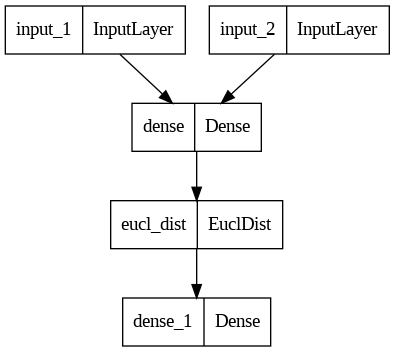

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
# Hay que definir los vectores de entrada de forma independiente
x_train_v1 = dataset_x_train[:, 0, :]
x_train_v2 = dataset_x_train[:, 1, :]
x_test_v1 = dataset_x_test[:, 0, :]
x_test_v2 = dataset_x_test[:, 1, :]

num_epochs = 10
loss_train = []
loss_test = []
acc_train = []
acc_test = []
for epoch in range(num_epochs):
  # En el fit, predict y evaluate debemos pasar como input una lista con todos
  # los vectores que el modelo necesita
  hist = model.fit([x_train_v1, x_train_v2], dataset_y_train,
                   validation_data = ([x_test_v1, x_test_v2], dataset_y_test))
  loss_train.append(hist.history["loss"])
  loss_test.append(hist.history["val_loss"])
  acc_train.append(hist.history["acc"])
  acc_test.append(hist.history["val_acc"])


1563/1563 [==============================] - 7s 4ms/step - loss: 0.1369 - acc: 0.9907 - val_loss: 0.1292 - val_acc: 0.9936


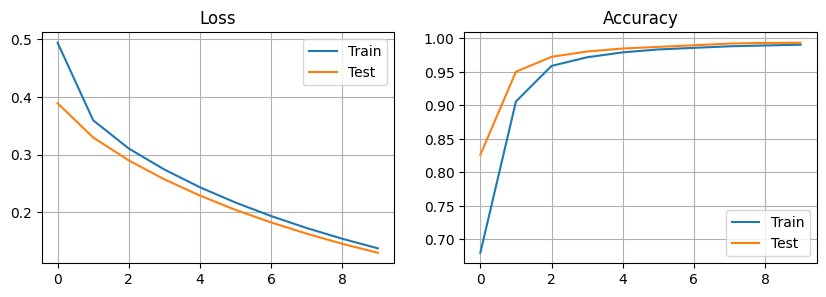

In [37]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(loss_train, label="Train")
plt.plot(loss_test, label="Test")
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(acc_train, label="Train")
plt.plot(acc_test, label="Test")
plt.legend()
plt.grid()
plt.show()

## Ejercicio 2

El objetivo de este ejercicio consiste en diseñar una red que reciba dos imágenes y te diga si su diferencia (A - B) es mayor que 1, mayor que 2 o mayor que 3. Lo interesante aquí es que aquellas que sean mayor que 3, también serán mayor que 2 y mayor que 1, por tanto estamos en un **problema multietiqueta**.

El modelo debe no solo aprender a identificar los números, sino también debe ser capaz de restar los dígitos que representa. Veamos si somos capaces de hacerlo.

En primer lugar, construimos el dataset.

In [54]:
# En esta celda estamos construyendo el dataset nuevo. El procedimiento es el siguiente:
#  1. Selección aleatoria de dos imágenes de entrenamiento: imagen1 y imagen2
#  2. Guardamos:
#     |imagen1 - imagen2| > 1 como etiqueta1
#     |imagen1 - imagen2| > 2 como etiqueta2
#     |imagen1 - imagen2| > 3 como etiqueta3

dataset_x_train = []
dataset_y_train = []
train_size = 50000
for i in range(train_size):
  i1 = np.random.choice(len(train_images))
  i2 = np.random.choice(len(train_images))
  dataset_x_train.append([train_images[i1].reshape(28*28), train_images[i2].reshape(28*28)])
  et1 = train_labels[i1].astype(int)
  et2 = train_labels[i2].astype(int)
  dataset_y_train.append([np.abs(et1 - et2) > 1, np.abs(et1 - et2) > 2, np.abs(et1 - et2) > 3])

dataset_x_train = np.array(dataset_x_train)
dataset_y_train = np.array(dataset_y_train)

# Mismo procedimiento para el test

dataset_x_test = []
dataset_y_test = []
test_size = 20000
for i in range(test_size):
  i1 = np.random.choice(len(dataset_x_test_raw))
  i2 = np.random.choice(len(dataset_x_test_raw))
  dataset_x_test.append([test_images[i1].reshape(28*28), test_images[i2].reshape(28*28)])
  et1 = test_labels[i1].astype(int)
  et2 = test_labels[i2].astype(int)
  dataset_y_test.append([np.abs(et1 - et2) > 1, np.abs(et1 - et2) > 2, np.abs(et1 - et2) > 3])

dataset_x_test = np.array(dataset_x_test)
dataset_y_test = np.array(dataset_y_test)

In [58]:
dataset_x_train.shape, dataset_y_train.shape

((50000, 2, 784), (50000, 3))

Vamos a programar la función de construcción de nuestro modelo.

In [113]:
def build_model(input_dim, units1, units2, optimizer="Adam"):
    ###########################################
    # TO-DO
    # Construye el modelo que reciba 2 entradas con dimension input_dim
    # Luego, utiliza una capa densa con units1 neuronas que procese las dos entradas
    # Luego, concatena las dos entradas usando tf.keras.layers.Concatenate()
    # Luego, utiliza una capa densa con units2 neuronas que procese el vector concatenado
    # Luego, construye 3 capas (para tomar las 3 decisiones) con activación sigmoid
    #

    input_layer_v1 = tf.keras.Input(shape=(input_dim))
    input_layer_v2 = tf.keras.Input(shape=(input_dim))
    dense_layer = tf.keras.layers.Dense(units1, activation="relu")
    dense_layer_v1 = dense_layer(input_layer_v1)
    dense_layer_v2 = dense_layer(input_layer_v2)
    concat_layer = tf.keras.layers.Concatenate()([dense_layer_v1, dense_layer_v2])
    dense_layer = tf.keras.layers.Dense(units2, activation="relu")(concat_layer)
    output_layer_mayor1 = tf.keras.layers.Dense(1, activation="sigmoid", name="m1")(dense_layer)
    output_layer_mayor2 = tf.keras.layers.Dense(1, activation="sigmoid", name="m2")(dense_layer)
    output_layer_mayor3 = tf.keras.layers.Dense(1, activation="sigmoid", name="m3")(dense_layer)

    model = tf.keras.Model(inputs=[input_layer_v1, input_layer_v2],
                           outputs=[output_layer_mayor1, output_layer_mayor2, output_layer_mayor3])
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])
    #
    ###########################################
    return model

In [114]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model = build_model(28*28, 50, 50, optimizer=optimizer)
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 dense_34 (Dense)            (None, 50)                   39250     ['input_33[0][0]',            
                                                                     'input_34[0][0]']            
                                                                                                  
 concatenate_15 (Concatenat  (None, 100)                  0         ['dense_34[0][0]',     

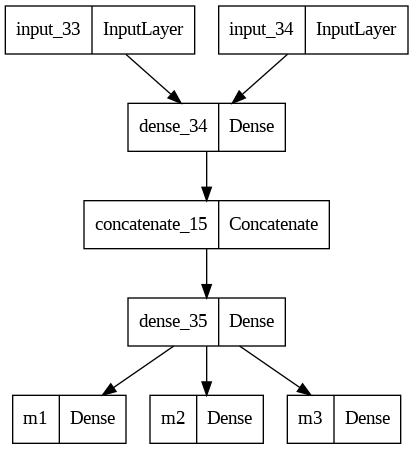

In [115]:
tf.keras.utils.plot_model(model)

In [116]:
# Hay que definir los vectores de entrada de forma independiente
x_train_v1 = dataset_x_train[:, 0, :]
x_train_v2 = dataset_x_train[:, 1, :]
x_test_v1 = dataset_x_test[:, 0, :]
x_test_v2 = dataset_x_test[:, 1, :]

y_train_v1 = dataset_y_train[:, 0]
y_train_v2 = dataset_y_train[:, 1]
y_train_v3 = dataset_y_train[:, 2]
y_test_v1 = dataset_y_test[:, 0]
y_test_v2 = dataset_y_test[:, 1]
y_test_v3 = dataset_y_test[:, 2]


num_epochs = 20
loss_train = []
loss_test = []
acc_train_m1 = []
acc_train_m2 = []
acc_train_m3 = []
acc_test_m1 = []
acc_test_m2 = []
acc_test_m3 = []
for epoch in range(num_epochs):
  # En el fit, predict y evaluate debemos pasar como input una lista con todos
  # los vectores que el modelo necesita
  # Además, debemos pasar como output una lista con todos los vectores que el
  # modelo necesita
  hist = model.fit([x_train_v1, x_train_v2], [y_train_v1, y_train_v2, y_train_v3],
                   validation_data = ([x_test_v1, x_test_v2], [y_test_v1, y_test_v2, y_test_v3]))
  loss_train.append(hist.history["loss"])
  loss_test.append(hist.history["val_loss"])
  acc_train_m1.append(hist.history["m1_acc"])
  acc_train_m2.append(hist.history["m2_acc"])
  acc_train_m3.append(hist.history["m3_acc"])
  acc_test_m1.append(hist.history["val_m1_acc"])
  acc_test_m2.append(hist.history["val_m2_acc"])
  acc_test_m3.append(hist.history["val_m3_acc"])

1563/1563 [==============================] - 7s 4ms/step - loss: 0.0910 - m1_loss: 0.0295 - m2_loss: 0.0313 - m3_loss: 0.0302 - m1_acc: 0.9900 - m2_acc: 0.9888 - m3_acc: 0.9897 - val_loss: 0.9777 - val_m1_loss: 0.2776 - val_m2_loss: 0.3570 - val_m3_loss: 0.3431 - val_m1_acc: 0.9305 - val_m2_acc: 0.9156 - val_m3_acc: 0.9214


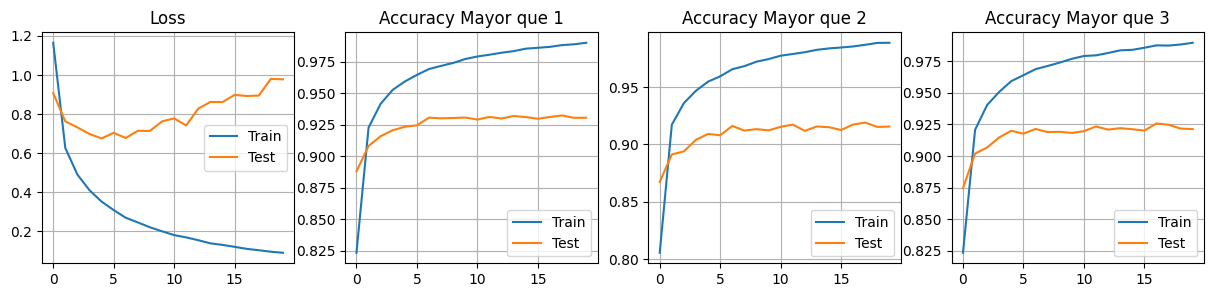

In [117]:
plt.figure(figsize=(15, 3))
plt.subplot(1,4,1)
plt.title("Loss")
plt.plot(loss_train, label="Train")
plt.plot(loss_test, label="Test")
plt.legend()
plt.grid()
plt.subplot(1,4,2)
plt.title("Accuracy Mayor que 1")
plt.plot(acc_train_m1, label="Train")
plt.plot(acc_test_m1, label="Test")
plt.legend()
plt.grid()
plt.subplot(1,4,3)
plt.title("Accuracy Mayor que 2")
plt.plot(acc_train_m2, label="Train")
plt.plot(acc_test_m2, label="Test")
plt.legend()
plt.grid()
plt.subplot(1,4,4)
plt.title("Accuracy Mayor que 3")
plt.plot(acc_train_m3, label="Train")
plt.plot(acc_test_m3, label="Test")
plt.legend()
plt.grid()
plt.show()